Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [274]:
from itertools import combinations
import numpy as np
from typing import List, Tuple
from icecream import ic
import matplotlib.pyplot as plt
import random
from copy import deepcopy

## Simple Test Problem

In [275]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

## Common tests

In [276]:
problem = np.load('lab2/problem_r2_100.npy')

In [277]:
# Negative values?
np.any(problem < 0)

np.True_

In [278]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

False

In [279]:
# Symmetric matrix?
np.allclose(problem, problem.T)

False

In [280]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

False

## Utility Functions

In [ ]:
def tour_distance(tour: np.ndarray, distances: np.ndarray) -> float:
    """
        Calculate the total distance of the given tour.
    """
    total_distance = 0.0
    for i in range(len(tour)):
        total_distance += distances[tour[i], tour[(i + 1) % len(tour)]]
    return total_distance

### Mutation functions

- **Inversion mutation** : selects two random positions within the tour and reverses the order of all cities contained in the segment between these two points. It is a local mutation that preserves most of the original tour structure while modifying only the visiting sequence of a specific segment;

- **Three-opt mutation**: selects three random cutting points in the tour and reorganizes the resulting segments in a different order by concatenating them as: first segment, third segment, second segment, and fourth segment.

In [ ]:
def inversion_mutation(tour: np.ndarray) -> np.ndarray:
    """
        Perform inversion mutation on the given tour. Reverses a segment of the tour.
    """

    # Select two mutation points
    
    # avoid creating a copy of tour
    # tour = tour.copy()
    
    size = len(tour)
    start = random.randint(0, size - 2)
    end = random.randint(start + 1, size)

    # Invert the segment between the two points
    tour[start:end] = tour[start:end][::-1]

    return tour

def swap_mutation(tour: np.ndarray) -> np.ndarray:
    """
        Perform swap mutation on the given tour. Swaps two cities in the tour.
    """

    # avoid creating a copy of tour
    # tour = tour.copy()
    size = len(tour)

    # Select two mutation points
    i, j = np.random.choice(size, 2, replace=False)
    tour[i], tour[j] = tour[j], tour[i]

    return tour


mutation_functions = [inversion_mutation, swap_mutation]

### Crossover functions

- **Ordered crossover (OX)** : selects two random cutting points in both parent tours and creates a child by preserving a segment from the first parent while filling the remaining positions with cities from the second parent in their original order;

- **Inver-over crossover**: creates a child by starting from a copy of the first parent, then selects a random city in the child and finds its successor in the second parent. It then locates this successor city in the child and reverses the segment between these two cities, performing a directed inversion operation.

In [283]:
def ox_crossover(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
        """
            Perform ordered crossover between two parents to produce a child tour.
        """

        size = len(parent1)
        
        # Select two crossover points
        start = random.randint(0, size - 1)
        end = random.randint(0, size - 1)
        start, end = min(start, end), max(start, end)

        # Create child tour with -1 placeholders and copy the segment from parent1
        child = np.full(size, -1, dtype=int)
        child[start:end] = parent1[start:end]

        used_cities = set(parent1[start:end])

        # Fill in the remaining cities from parent2 in order that are not already in the child
        current_pos = end
        for city in parent2:
            if city not in used_cities:
                if current_pos >= size:
                    current_pos = 0
                child[current_pos] = city
                current_pos += 1

        return child

def inver_over_crossover(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
    """
        Perform inver-over crossover between two parents to produce a child tour.
    """
    size = len(parent1)

    # Create child as a copy of parent1
    child = parent1.copy()

    # Select a random city in the child
    i = random.randint(0, size - 1)
    city_a = child[i]

    # Find the successor of the selected city in parent2
    city_b = parent2[(np.where(parent2 == city_a)[0][0] + 1) % size]

    # Find the position of city_b in the child
    j = np.where(child == city_b)[0][0]
    
    # Reverse the segment between city_a and city_b in the child
    if i < j:
        child[i+1:j+1] = child[i+1:j+1][::-1]
    else:
        child[j+1:i+1] = child[j+1:i+1][::-1]
        
    return child

crossover_functions = [ox_crossover,inver_over_crossover]

## Genetic Algorithm

The genetic algorithm implementation follows a structured approach to solve the TSP through evolutionary computation.

The algorithm begins by creating a diverse initial population using completely random permutations of cities, ensuring maximum genetic diversity at the start of the evolutionary process.

Parent selection employs a tournament-based mechanism where individuals are randomly sampled from the population, and the fittest candidate (shortest tour distance) is selected as a parent.

**Main Solver Function** :

The core evolutionary loop implements several key mechanisms:

- The mutation probability dynamically adjusts based on evolutionary progress;

- The top 5% of the population are directly transferred to the next generation without modification;

- Each generation follows a complete cycle: tournament selection identifies parents, crossover, probabilistic mutation, and fitness evaluation measures tour quality.


In [ ]:
def initialize_population(distances: np.ndarray, population_size: int) -> List[np.ndarray]:
    """
        Initialize the population with diverse tours.
    """
    population = []


    # Random tours
    for _ in range(population_size):
        tour = np.random.permutation(distances.shape[0])
        population.append(tour)

    return population

def nearest_neighbor_tour(distances: np.ndarray, start_city: int) -> np.ndarray:
        """
            Generate a tour using the nearest neighbor.
        """

        # Start from the given city
        tour = [start_city]

        # Keep track of unvisited cities
        unvisited = set(range(distances.shape[0]))
        unvisited.remove(start_city)

        while unvisited:
            last_visited = tour[-1]
            # Find the nearest unvisited city to the last visited city
            next_city = min(unvisited, key=lambda city: distances[last_visited, city])
            tour.append(next_city)
            unvisited.remove(next_city)

        return np.array(tour)

def tournament_selection_idx(tournament_size: int, population_distances: np.ndarray) -> int:
    """
        Tournament selection that returns the index of the winner.
    """

    # Select candidate indices from the population
    candidates = random.sample(range(len(population_distances)), tournament_size)

    # Select the best candidate (minimum distance)
    winner = candidates[np.argmin(population_distances[candidates])]

    return winner


def solve(distances: np.ndarray, mutation_function, crossover_function, 
          population_size: int = 100,
          tournament_size: int = 5, generations: int = 500) -> Tuple[np.ndarray, float, List[float]]:
    """
        Solve the TSP problem using a genetic algorithm.
    """
    
    # Initialize population
    population = initialize_population(distances, population_size)
    population_distances = np.array([tour_distance(tour, distances) for tour in population])
    
    best_tour = None
    best_distance = float('inf')
    history = []

    elitism_size = population_size // 20 

    for gen in range(generations):

        # Adjust mutation rate over generations 
        progress = gen / generations
        if progress < 0.3:
            mutation_rate = 0.3
        elif progress < 0.7:
            mutation_rate = 0.2  
        else:
            mutation_rate = 0.1  

        # Order population by distance
        indices = np.argsort(population_distances)

        current_best_distance = population_distances[indices[0]]

        # Update global best
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_tour = population[indices[0]].copy()
        
        history.append(best_distance)

        # Create new population with elitism
        new_population = [population[i] for i in indices[:elitism_size]]
        new_population_distances = [population_distances[i] for i in indices[:elitism_size]]

        # Generate the rest of the new population
        while len(new_population) < population_size:

            # Selection
            p1_index = tournament_selection_idx(tournament_size, population_distances)
            p2_index = tournament_selection_idx(tournament_size, population_distances)

            # Crossover
            child = crossover_function(population[p1_index], population[p2_index])

            # Mutation
            if random.random() < mutation_rate:
                # modify directly the child np.array,
                # without creating a copy of it
                mutation_function(child)

            child_distance = tour_distance(child, distances)

            new_population.append(child)
            new_population_distances.append(child_distance)

        population = new_population
        population_distances = np.array(new_population_distances)
            
    return best_tour, best_distance, history

## Test problems

### Utility function
Tests all 4 possible strategy combinations (2 mutations × 2 crossovers) on a TSP problem, plots a graph showing how the best cost evolves across generations for each strategy, and returns the winning combination (the one with the lowest final cost).

In [ ]:
def test_problem(problem_path: str, problem_name: str, 
                 population_size: int, generations: int):
    """
        Test TSP problem with all mutation/crossover combinations.
    """
    problem = np.load(problem_path)
    problem_best_tour = None
    problem_best_cost = float('inf')
    problem_best_strategy = None

    print(f"PROBLEM: {problem_name}")
    
    plt.figure(figsize=(14, 8))
    
    for mut in mutation_functions:
        for cross in crossover_functions:
            best_route, best_cost, best_history = solve(
                problem, 
                mut, 
                cross,
                population_size=population_size,
                generations=generations
            )

            label = f"{cross.__name__[:-9]} + {mut.__name__[:-9]}"
            print(f"{label} -> Cost: {best_cost:.2f}")
            
            if best_cost < problem_best_cost:
                problem_best_cost = best_cost
                problem_best_tour = best_route
                problem_best_strategy = label
            
            plt.plot(best_history, label=label)
    
    plt.xlabel('Generation')
    plt.ylabel('Best Cost')
    plt.title(f'Mutation + Crossover Combinations - {problem_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Best overall strategy: {problem_best_strategy}")
    print(f"Best overall cost: {problem_best_cost:.2f}")
    print(f"Best overall tour: {problem_best_tour}")
    print("=" * 40 )
    
    return problem_best_tour, problem_best_cost, problem_best_strategy

## G problems

PROBLEM: G_10
ox_ + inversion -> Cost: 1497.66
inver_over_ + inversion -> Cost: 1497.66
ox_ + swap -> Cost: 1497.66
inver_over_ + swap -> Cost: 1497.66


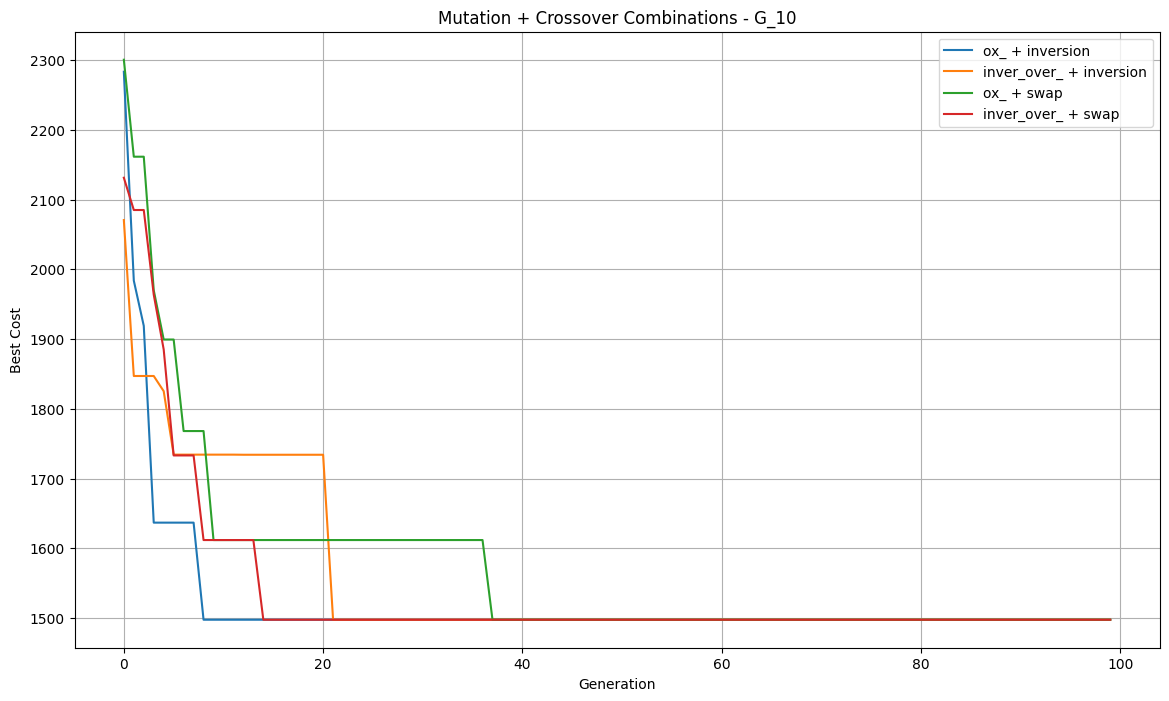

Best overall strategy: ox_ + inversion
Best overall cost: 1497.66
Best overall tour: [3 2 8 0 7 9 5 4 6 1]
PROBLEM: G_20
ox_ + inversion -> Cost: 1755.51
inver_over_ + inversion -> Cost: 1787.88
ox_ + swap -> Cost: 1755.51
inver_over_ + swap -> Cost: 2274.13


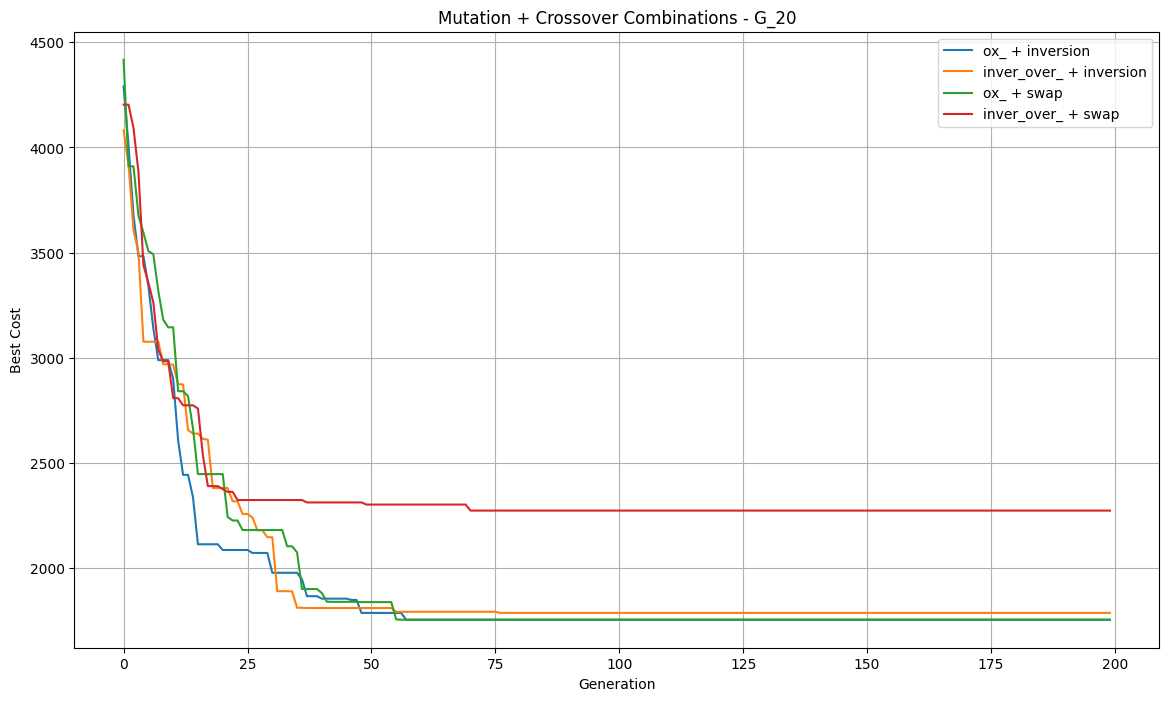

Best overall strategy: ox_ + inversion
Best overall cost: 1755.51
Best overall tour: [ 3  8  6 13 11  0  5 18 10  4 17  2  9 12  7  1 16 14 19 15]
PROBLEM: G_50
ox_ + inversion -> Cost: 2894.65
inver_over_ + inversion -> Cost: 2852.15
ox_ + swap -> Cost: 3119.63
inver_over_ + swap -> Cost: 3327.44


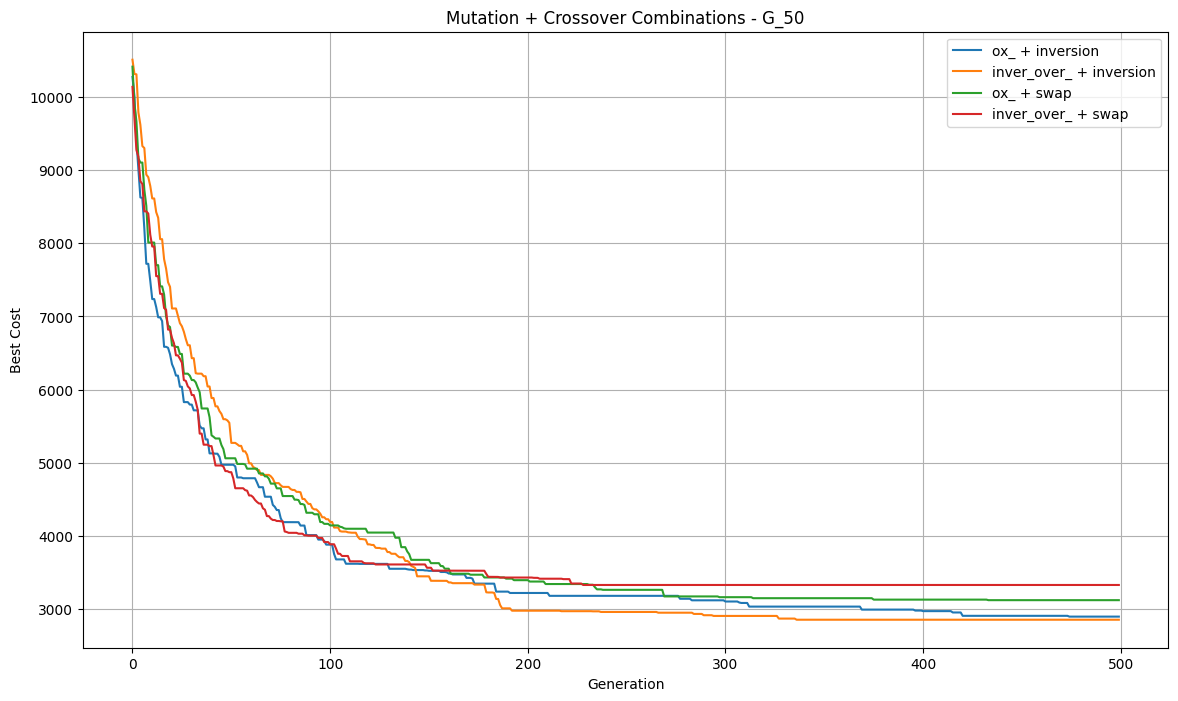

Best overall strategy: inver_over_ + inversion
Best overall cost: 2852.15
Best overall tour: [26 17  8 48 40 25 14  0 27 23 30  5 28 15 13 35 16 45 44  6  7 34 43 22
 10  3 11  4 29 32 42 24 19  9  2 47 46 18 20 31 37 21 33 36 41  1 12 49
 38 39]
PROBLEM: G_100
ox_ + inversion -> Cost: 4725.14
inver_over_ + inversion -> Cost: 4410.12
ox_ + swap -> Cost: 5455.05
inver_over_ + swap -> Cost: 5251.83


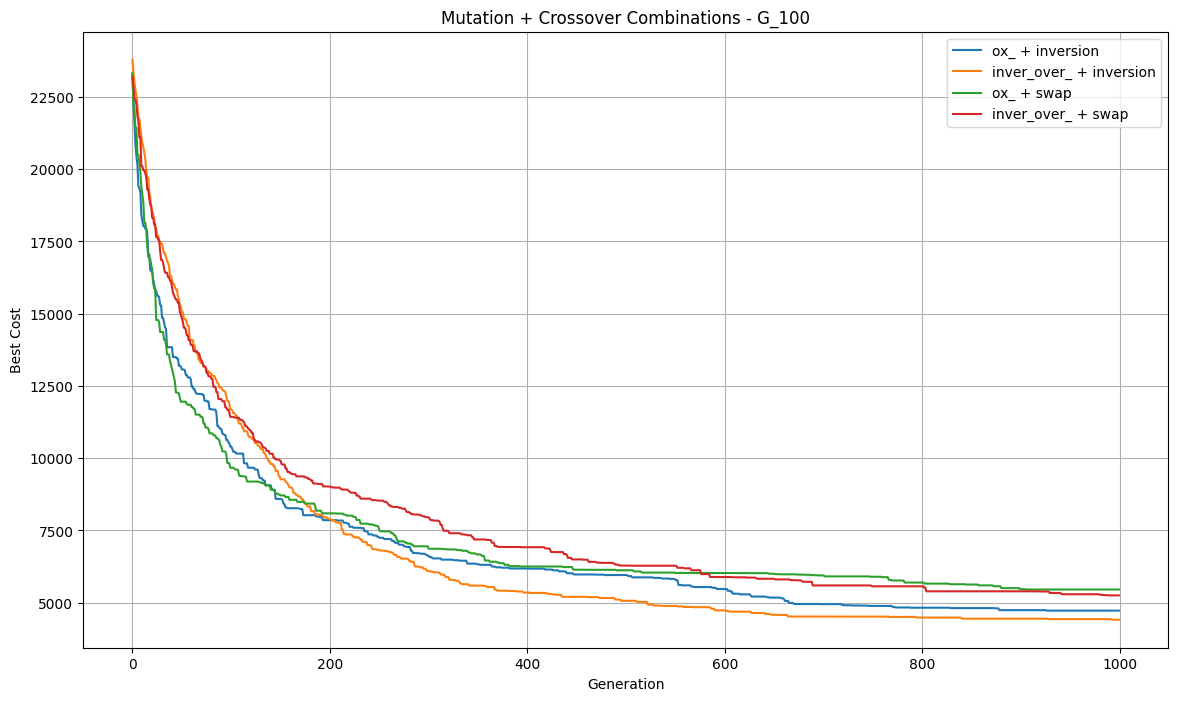

Best overall strategy: inver_over_ + inversion
Best overall cost: 4410.12
Best overall tour: [11 60 21 28 51  3 84 66 79 45 73 53 70 57 41 14  0 74 20 27 71 47 63 99
 93 46 36  7  5 49 22 69  1  8  4 55 75 34 87 86 43 92 88 78 12  6 77 91
 15 50 24 40 19 80 25 96 98 39 65 82 61 23  9 59 29 62 95 38 35 17 44 94
 16 90 76 13 26 83 85 89 52 68 81 30 97 64 42 10 32 37 33 54 67 48 31 72
 18 56 58  2]
PROBLEM: G_200
ox_ + inversion -> Cost: 8704.00
inver_over_ + inversion -> Cost: 6776.76
ox_ + swap -> Cost: 8793.71
inver_over_ + swap -> Cost: 10091.29


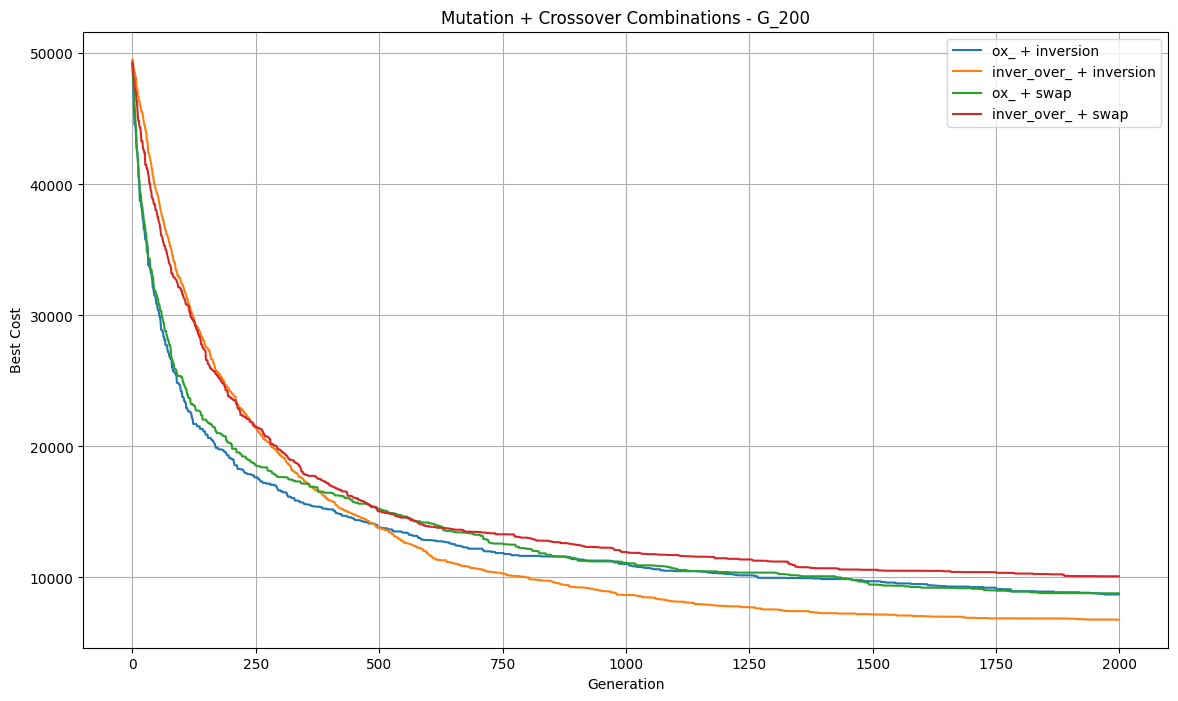

Best overall strategy: inver_over_ + inversion
Best overall cost: 6776.76
Best overall tour: [130  18  93  68  31  54 103   5 158  39  13 101  22 118  50  47  29 147
 190  91  69 166 145 182  89 141 121  87  25  73  92 151   2 175 119  80
  82  21  48 196 157 126 116 123  85  86 144  59 197  62  42 140  71 100
  51  97  40 171  41 117  67 124 181 185  77 132  57  74 131 146 143 156
  10  56  66 106 128  76 178 138  99 193 172 125 112  64  19 165 170 155
  53  78 111   1 176  52  17 133 102 142   7  27  81  33 110   8   0  60
 183 139 136  24 169  37  88 122  34   3  75 127  45  49  35  94 162  55
  83 153  16 137 180 159 129 109  23 198  90 188  79  63  20  28  26 174
 168 187 120  72  15 105  58 161 189  44  36 113 177   4  32  70 149  95
 135  96 163  14 134 179 164 108  12  84 152 114  65 192 195 191  61  11
  30 194 150  43  38   9  46   6 186 167  98 154 160 148 115 107 199 173
 184 104]
PROBLEM: G_500
ox_ + inversion -> Cost: 19397.89
inver_over_ + inversion -> Cost: 13404.03
ox_

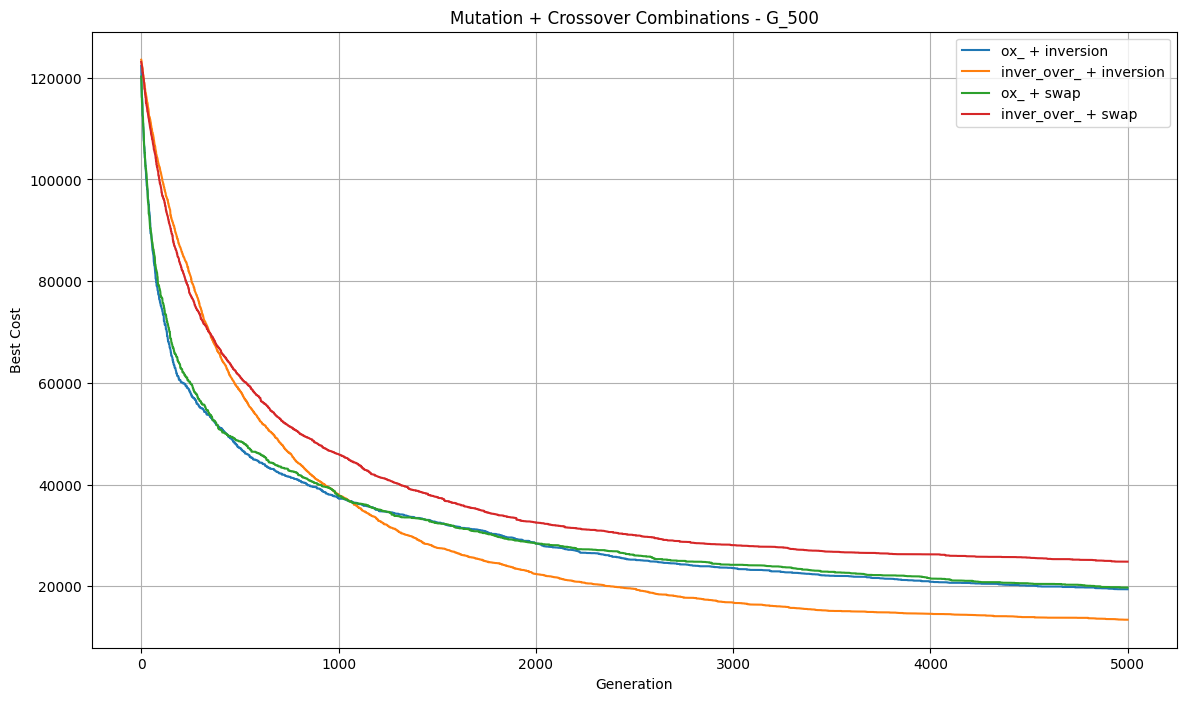

Best overall strategy: inver_over_ + inversion
Best overall cost: 13404.03
Best overall tour: [ 26 401  77 185  80 306 183 303 494 356 211 358 273 291 348 381 159 197
 421 223 376 463 325 461  88 404 499  10 420 264 106 400 212 355 227 193
  66 329 295 276  30 140 271  72 174 109   8 353 247 361 188 231 450  20
 189 357 131 139  73 136 316 344 203 426 417 143 428 467 449 182  74 215
  14 122 121 493 221 490 479 436 397 255 460 406 410 192 208 402 281 349
 315 260 219 112 439 137 101 299 340  62  98 481 491 199 172 314 184 416
 446  12 482 277 202 274 458 171 155 313 257 369  96 169 354 497 164 179
 367 453 440 471 218 371 437 484 391 485  50 100 204 113 379 305 249 248
  56 495 333 253 200 390 352 108   0 132 288 168 342 456 312  68 457 158
 498 261  29 373 483 191  45 374  55 222 477 123 165  44 177 190 244 145
 469 104  39 267 285 350 129  78 365 472 339 393 418 383 395  53 377 194
  43  99 134 186  17  40 310 431  70 284 487 150  75 144 270  91  97 166
 147 362 272  37 335 119 278  

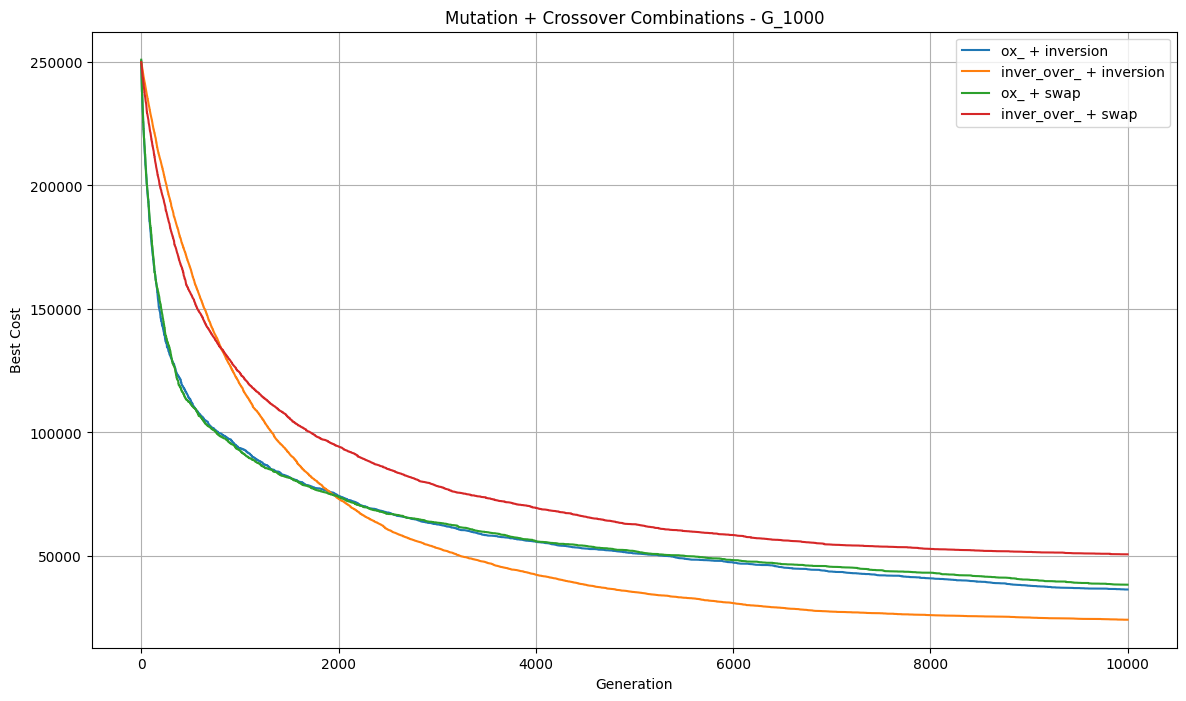

Best overall strategy: inver_over_ + inversion
Best overall cost: 24153.18
Best overall tour: [688 396 586 225 113 592  70   5  10 916 300 435  73 659 840 142 372 451
 191 564 979 596 367 648 490 329 169 261 547 263   7 287 629  34 525 535
   1 846 360 266 854 243 294 925 217 745  21 466 251 153 533 988 827 493
 703 299 202  16 892 981 208 775 223 264 805 165 288 793 753 589 946 219
 691 917  54 353 817 282 938 777 220 305 281 669 874 991 332 575 724 447
 426  80 262  11 849 715 233 408 222 754 532 101 221 936 771 843 780 893
 920 580 540 744 965 573 871 144 980 671 190 644  49 203 158 929 789 718
 118  95 311 700 956 345 788 757  72 966 693 553 407 747 960 738 734 797
 556 371 856 213 339 176 310 474 678 442 120 948 412 260 555 248 737 642
 253 873  27  92 876 710 344 864 722 230 878 185 157 951 379 445 866   3
 200 394 375 720 172  32 886 499  36 752 391 312 674 119 417  31 905 537
  12 978 377 772 791 425  44 352 716  57 546 609   0 684  52 361 760 134
 402 386 238 955 513 489  19 5

(array([688, 396, 586, 225, 113, 592,  70,   5,  10, 916, 300, 435,  73,
        659, 840, 142, 372, 451, 191, 564, 979, 596, 367, 648, 490, 329,
        169, 261, 547, 263,   7, 287, 629,  34, 525, 535,   1, 846, 360,
        266, 854, 243, 294, 925, 217, 745,  21, 466, 251, 153, 533, 988,
        827, 493, 703, 299, 202,  16, 892, 981, 208, 775, 223, 264, 805,
        165, 288, 793, 753, 589, 946, 219, 691, 917,  54, 353, 817, 282,
        938, 777, 220, 305, 281, 669, 874, 991, 332, 575, 724, 447, 426,
         80, 262,  11, 849, 715, 233, 408, 222, 754, 532, 101, 221, 936,
        771, 843, 780, 893, 920, 580, 540, 744, 965, 573, 871, 144, 980,
        671, 190, 644,  49, 203, 158, 929, 789, 718, 118,  95, 311, 700,
        956, 345, 788, 757,  72, 966, 693, 553, 407, 747, 960, 738, 734,
        797, 556, 371, 856, 213, 339, 176, 310, 474, 678, 442, 120, 948,
        412, 260, 555, 248, 737, 642, 253, 873,  27,  92, 876, 710, 344,
        864, 722, 230, 878, 185, 157, 951, 379, 445

In [286]:
# G_10 problem
test_problem('lab2/problem_g_10.npy', "G_10", population_size=50, generations=100)

# G_20 problem
test_problem('lab2/problem_g_20.npy', "G_20", population_size=60, generations=200)

# G_50 problem
test_problem('lab2/problem_g_50.npy', "G_50", population_size=80, generations=500)

# G_100 problem
test_problem('lab2/problem_g_100.npy', "G_100", population_size=100, generations=1000)

# G_200 problem
test_problem('lab2/problem_g_200.npy', "G_200", population_size=120, generations=2000)

# G_500 problem
test_problem('lab2/problem_g_500.npy', "G_500", population_size=150, generations=5000)

# G_1000 problem
test_problem('lab2/problem_g_1000.npy', "G_1000", population_size=200, generations=10000)

## R1 problems

PROBLEM: R1_10
ox_ + inversion -> Cost: 184.27
inver_over_ + inversion -> Cost: 188.93
ox_ + swap -> Cost: 184.27
inver_over_ + swap -> Cost: 202.52


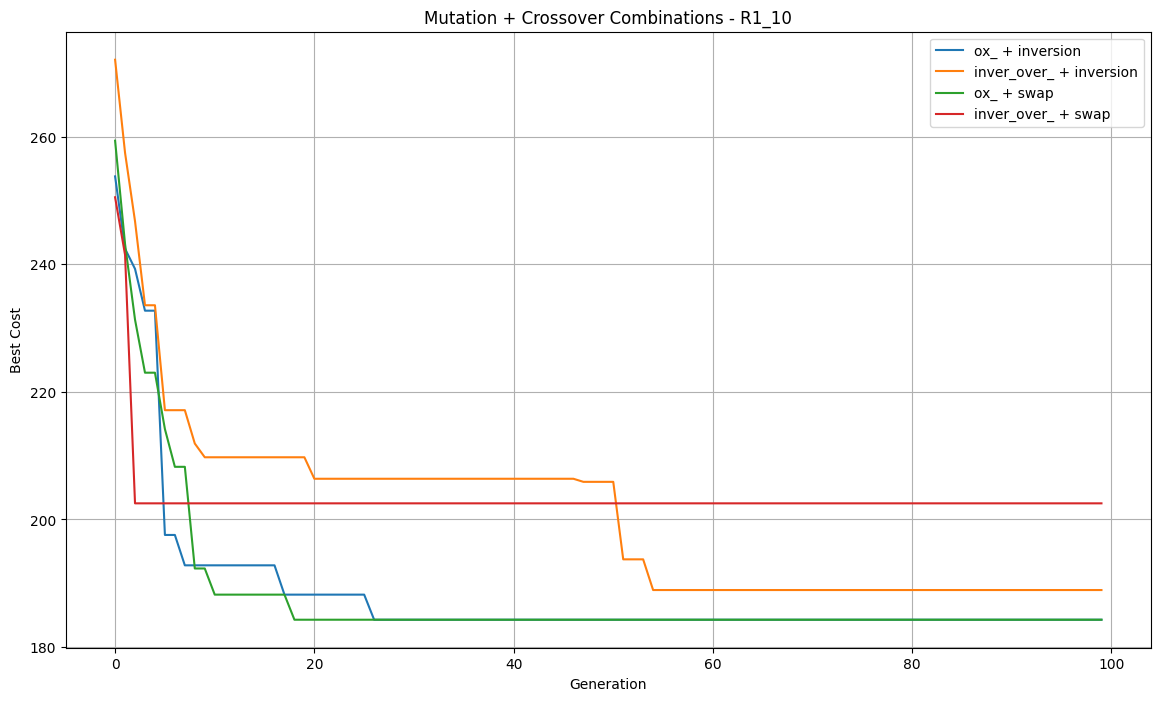

Best overall strategy: ox_ + inversion
Best overall cost: 184.27
Best overall tour: [0 4 5 3 6 2 9 7 1 8]
PROBLEM: R1_20
ox_ + inversion -> Cost: 354.70
inver_over_ + inversion -> Cost: 491.73
ox_ + swap -> Cost: 378.51
inver_over_ + swap -> Cost: 438.71


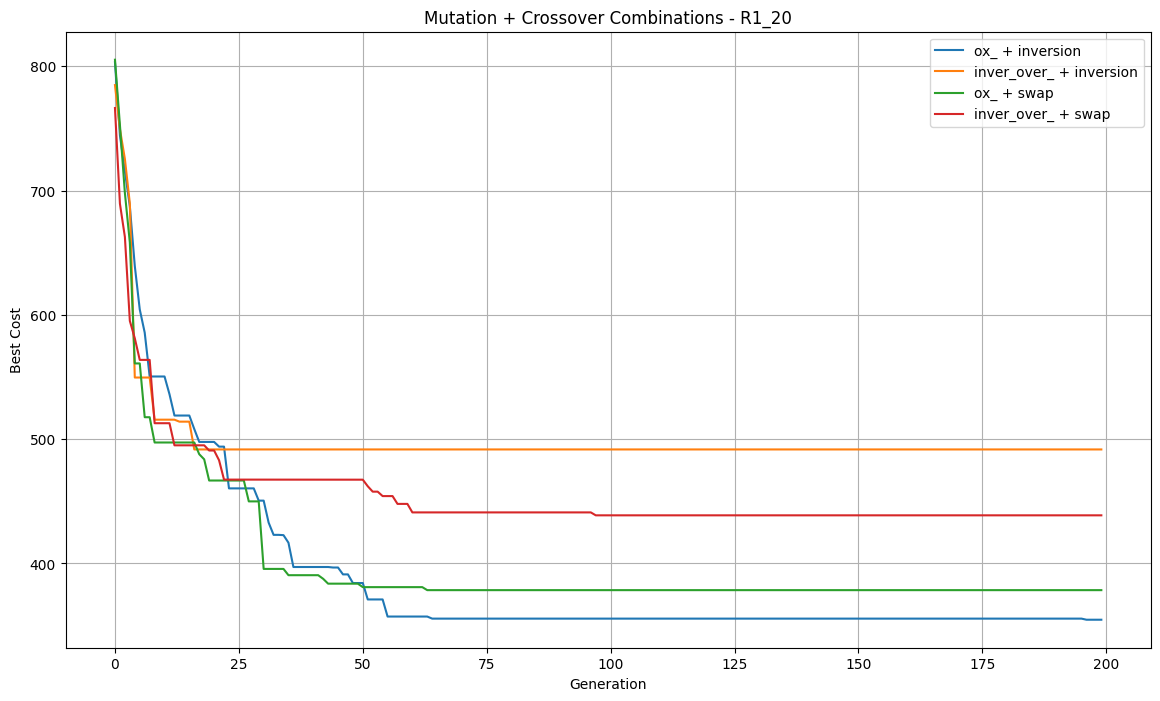

Best overall strategy: ox_ + inversion
Best overall cost: 354.70
Best overall tour: [10  5 11 18 14  2 19  0  3  4  1  9 12 16  7 17 15 13  6  8]
PROBLEM: R1_50
ox_ + inversion -> Cost: 653.99
inver_over_ + inversion -> Cost: 1112.66
ox_ + swap -> Cost: 651.19
inver_over_ + swap -> Cost: 858.45


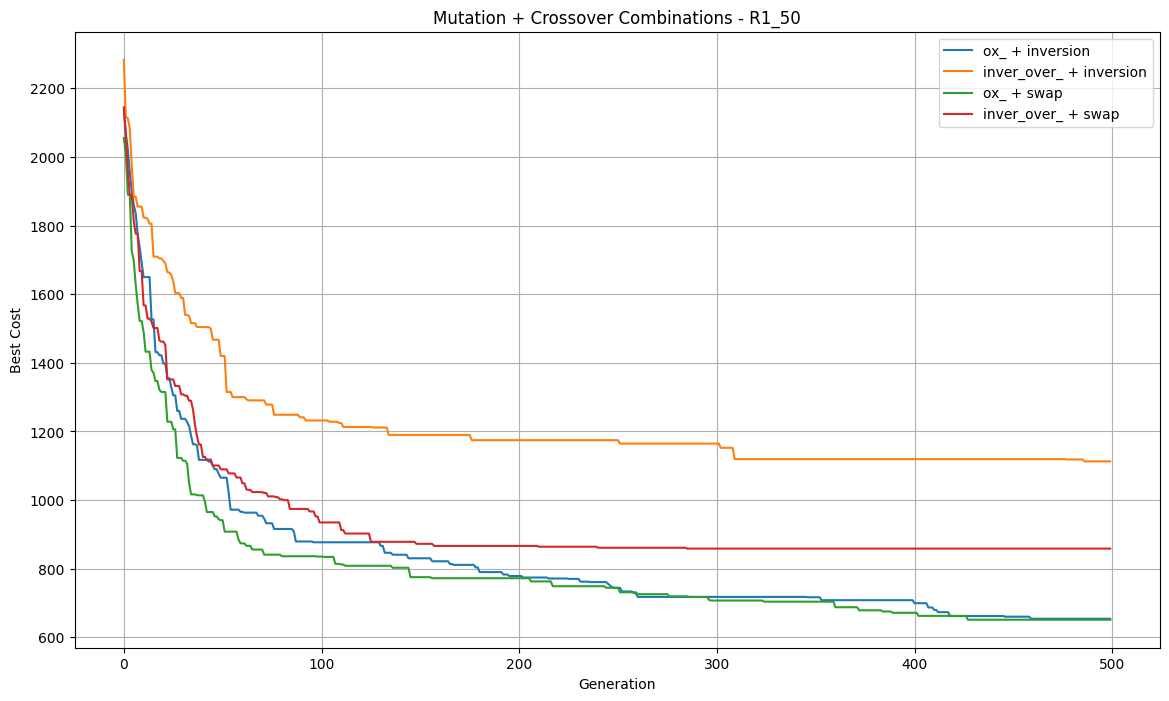

Best overall strategy: ox_ + swap
Best overall cost: 651.19
Best overall tour: [30  9  6 45 20  8 21 26 46  3 27 42 24  2 37 33 10 11 44 39 22 31 36 32
 48 18 41 16 17 12 25  4 19 47 28 35 40 38 43 23  7 49 14 34  0 15 29 13
  5  1]
PROBLEM: R1_100
ox_ + inversion -> Cost: 975.07
inver_over_ + inversion -> Cost: 2108.62
ox_ + swap -> Cost: 941.56
inver_over_ + swap -> Cost: 1311.19


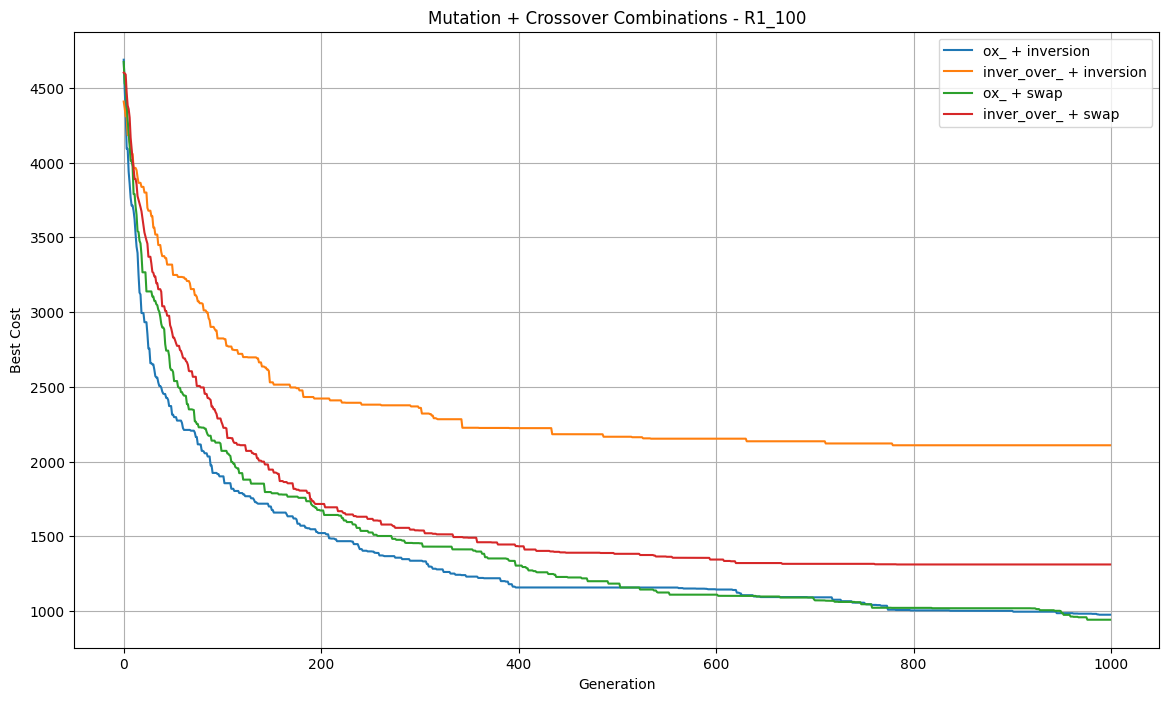

Best overall strategy: ox_ + swap
Best overall cost: 941.56
Best overall tour: [18 82 72 91 97 42 44 89 88 96 64 14  7 27 21 34 62 28 68 15 10 11 79  2
 50 81 29 99  8 35 52 73 69 95 93 74 26 87 70 25 78 37 46 77 83 20 65 55
 84 17 41 75  4 53  5 36 58 45 47 19 23 48 90 22 12 43 13 85 71 98 32 16
 56 30 60 40 86 57 24 80 94 51 38 49 54 31  9 76 61 39  6 67 66  3 33 63
 59 92  1  0]
PROBLEM: R1_200
ox_ + inversion -> Cost: 1753.88
inver_over_ + inversion -> Cost: 4023.03
ox_ + swap -> Cost: 1677.00
inver_over_ + swap -> Cost: 2681.20


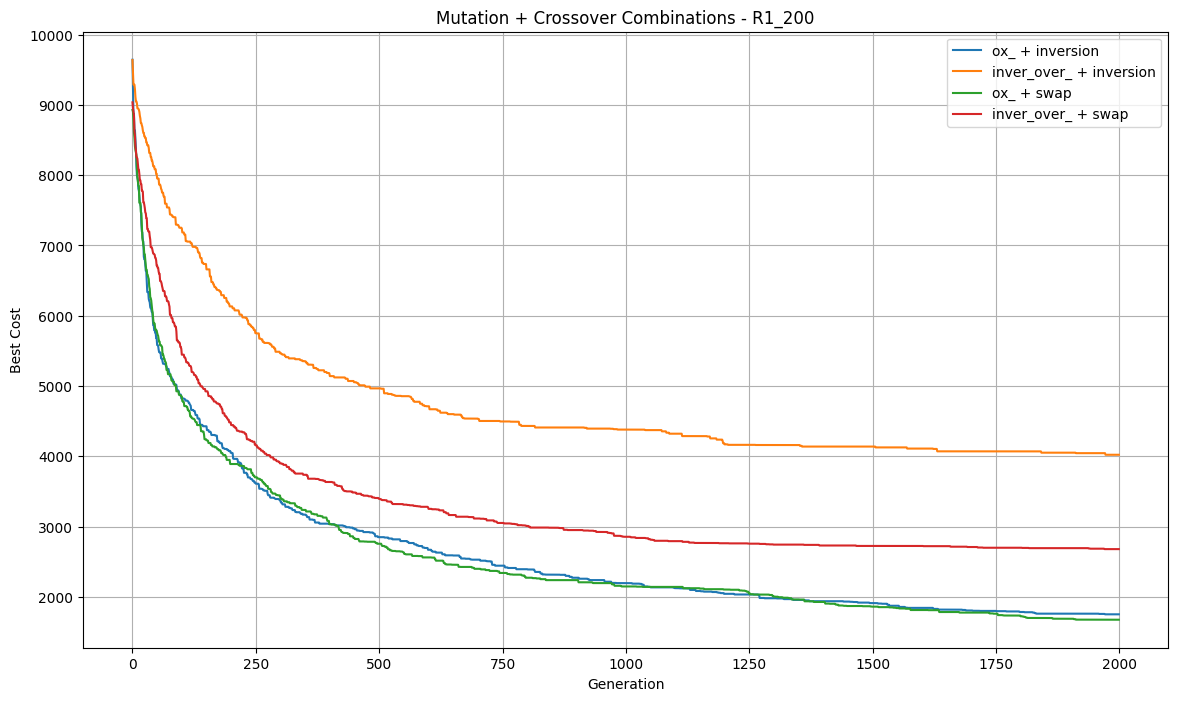

Best overall strategy: ox_ + swap
Best overall cost: 1677.00
Best overall tour: [ 54  89 152  22 105  94 158  37   3 197 117 127 185  68  92  24  17  72
  70 104  62 193  29  45 120  57  64  58 131 118  90  15 188  95 186 190
 133 109   0  80  18 175  56 147 122  84 145 138  53 141  79  13  99 114
 176 108 144 136  39   1 155  35 164 159  85  88 181  44  40 178 196 124
 125 173 150 135 123  60 191 168  26 194  96 111 112  61  87  98 134 165
 126 166 153  20  10   6 161 129 143 132  32 148  65  25  75  77  71 103
   5  73 169 101 187  78  46 154  12 198 130  97  36  67 195 179 183  41
 156  55  47  83  42 172 177  49  30  51   9  16 189  74  21  43 163 121
 110  50 128  86  38 151   2  48  19   4 199  66 162 182  69  28 139  34
 100  52  93 116 170   7  23 157  81  11 171  91  76  59 192 140  63 142
 149 167  14 113 137 115 107  31  27  33 146 174 184 106 160 102 180 119
  82   8]
PROBLEM: R1_500
ox_ + inversion -> Cost: 4240.16
inver_over_ + inversion -> Cost: 11632.74
ox_ + swap -> Co

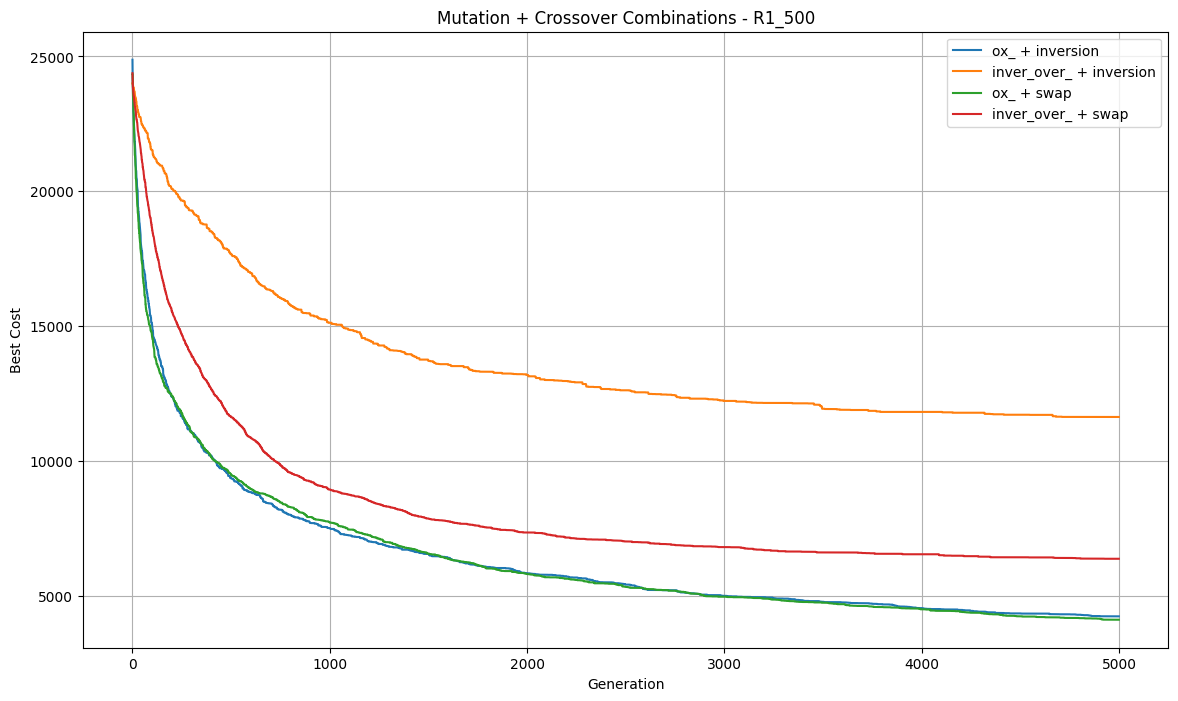

Best overall strategy: ox_ + swap
Best overall cost: 4114.78
Best overall tour: [469 434 350 208 366  85 484  99 139 319  60 265 348 201 329  76 143 266
 306  52 283   3 206 279 100  69 291 371 259 169  80 465 152 409 322 362
 426  40 276  78 440 216 274  50 428 454  59 117 495 321 170 412  70  27
  63 407 311 458  71 372  79 378 323 150 445 417  33 193 272 472  75 264
 277 286 470  64 427 196 132  29  86 448 188  38 334 136 421 456 396  26
  46 239 240 391 225  11  83 202  17 155 404   7 298  32 122 455 164 399
  42 420 459  61 263 220 242 179 349 360 270  98 498 128  10 338 398 352
 397 229 261 385 254 313 302 218 487 284 364 304 383 380 418 104 437  15
 444 410 280 345 269 133  72  20  24 129 181  95 373 203 415 346 138 110
 488 340 379  91  41 222 275 177  67 342 230 387 149 341 394   1 314  55
 318 101 268 271 160 485   4 260  58 256  81  97 347 107 248 130 438  45
 369 386 297 423 249 161 262   8 228 184 241 108 273 335 473 486 250 244
 126   0 462 165 253 406 299  82 173 489 317

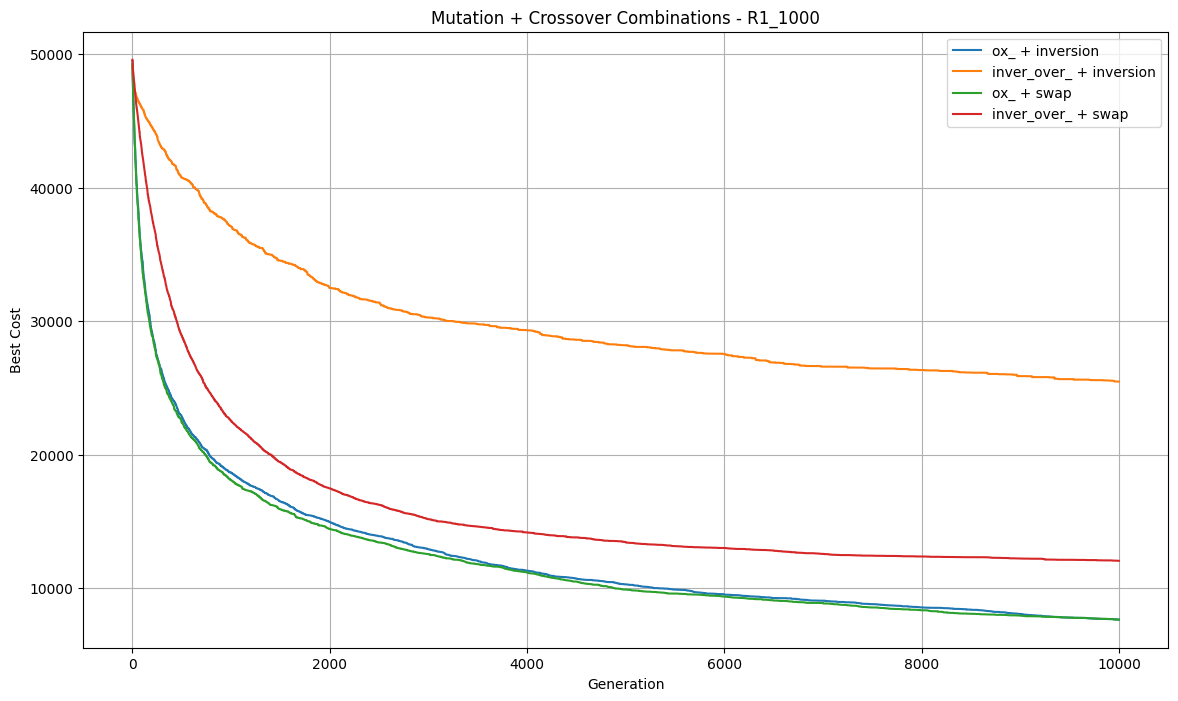

Best overall strategy: ox_ + swap
Best overall cost: 7645.06
Best overall tour: [883 632 754 748 285 646 794 165 813 291 484 960 716 868 812 634 305 898
 202 257 447 320 649 829 169 500 855 637 564 582 876 974 820 720 715 541
 816 214 576 253 645 968 836 460 266 950 178 933 342 413  85 666 232 603
  70 768 404 584 412 586  51 191 664 510 629 263 450 623 406 513 616 604
 728 611 399 852 548 643 588 677 602 369 886 411 926 563 663 157 988 487
 367 790  86 503 891 905 489 293 737 421 442 860  30 360 271 681 193 371
 815 134 973 656  82  36 594 781 128 589 987 403 947 561 706 464 521  50
 204 434 381 485 416 147 458 424 877 449  12 354 992 552 277 955 203 110
 268 639 363 683 949 185 549 262 853 787 938  42 573 675 848 275 494 998
 216 745  54 760 707 143 325 647 423 507 415 516 644 402 601 393 195 158
 289 212 803 828 913 205 515 512 711 957 750 525 832 862 502 223 463 384
 148  60 791 346 107 793  93 420 443 939 882   0 514 126 160  15 872  75
 600  18 284   4 652 571 543 236 301 309 613

(array([883, 632, 754, 748, 285, 646, 794, 165, 813, 291, 484, 960, 716,
        868, 812, 634, 305, 898, 202, 257, 447, 320, 649, 829, 169, 500,
        855, 637, 564, 582, 876, 974, 820, 720, 715, 541, 816, 214, 576,
        253, 645, 968, 836, 460, 266, 950, 178, 933, 342, 413,  85, 666,
        232, 603,  70, 768, 404, 584, 412, 586,  51, 191, 664, 510, 629,
        263, 450, 623, 406, 513, 616, 604, 728, 611, 399, 852, 548, 643,
        588, 677, 602, 369, 886, 411, 926, 563, 663, 157, 988, 487, 367,
        790,  86, 503, 891, 905, 489, 293, 737, 421, 442, 860,  30, 360,
        271, 681, 193, 371, 815, 134, 973, 656,  82,  36, 594, 781, 128,
        589, 987, 403, 947, 561, 706, 464, 521,  50, 204, 434, 381, 485,
        416, 147, 458, 424, 877, 449,  12, 354, 992, 552, 277, 955, 203,
        110, 268, 639, 363, 683, 949, 185, 549, 262, 853, 787, 938,  42,
        573, 675, 848, 275, 494, 998, 216, 745,  54, 760, 707, 143, 325,
        647, 423, 507, 415, 516, 644, 402, 601, 393

In [287]:
# R1_10 problem
test_problem('lab2/problem_r1_10.npy', "R1_10", population_size=50, generations=100)

# R1_20 problem
test_problem('lab2/problem_r1_20.npy', "R1_20", population_size=60, generations=200)

# R1_50 problem
test_problem('lab2/problem_r1_50.npy', "R1_50", population_size=80, generations=500)

# R1_100 problem
test_problem('lab2/problem_r1_100.npy', "R1_100", population_size=100, generations=1000)

# R1_200 problem
test_problem('lab2/problem_r1_200.npy', "R1_200", population_size=120, generations=2000)

# R1_500 problem
test_problem('lab2/problem_r1_500.npy', "R1_500", population_size=150, generations=5000)

# R1_1000 problem
test_problem('lab2/problem_r1_1000.npy', "R1_1000", population_size=200, generations=10000)

## R2 problems

PROBLEM: R2_10
ox_ + inversion -> Cost: -411.70
inver_over_ + inversion -> Cost: -357.20
ox_ + swap -> Cost: -411.70
inver_over_ + swap -> Cost: -389.10


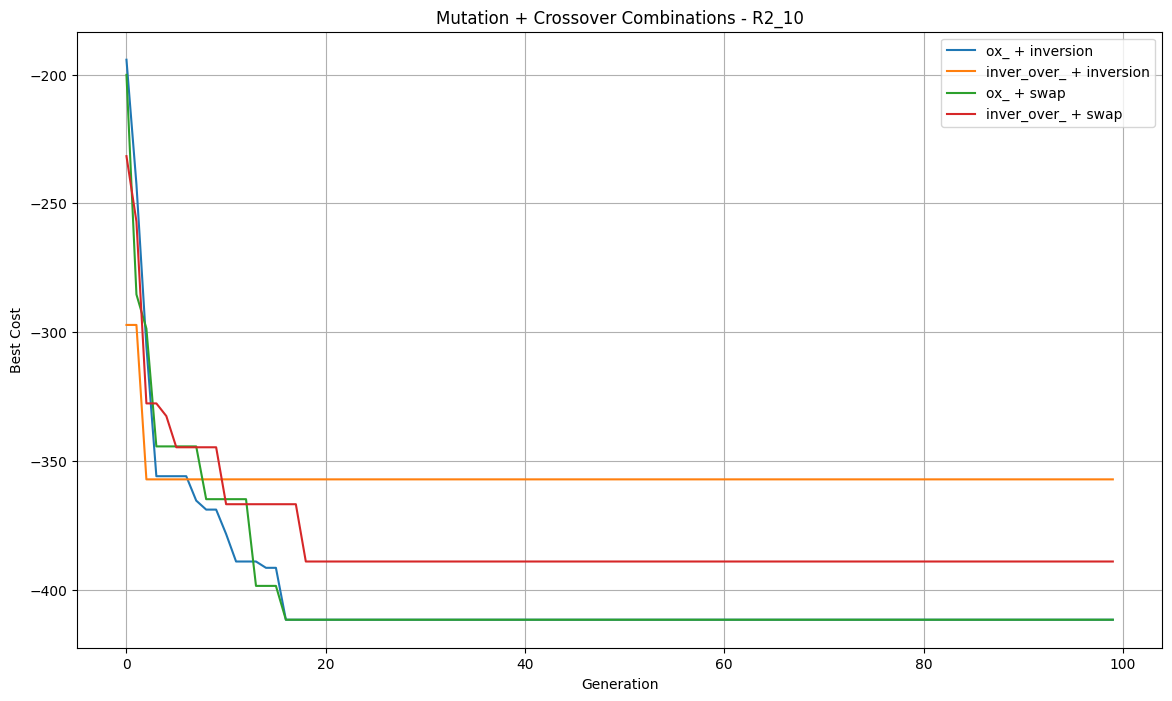

Best overall strategy: ox_ + inversion
Best overall cost: -411.70
Best overall tour: [8 1 9 5 0 2 7 6 3 4]
PROBLEM: R2_20
ox_ + inversion -> Cost: -825.79
inver_over_ + inversion -> Cost: -569.53
ox_ + swap -> Cost: -826.43
inver_over_ + swap -> Cost: -712.16


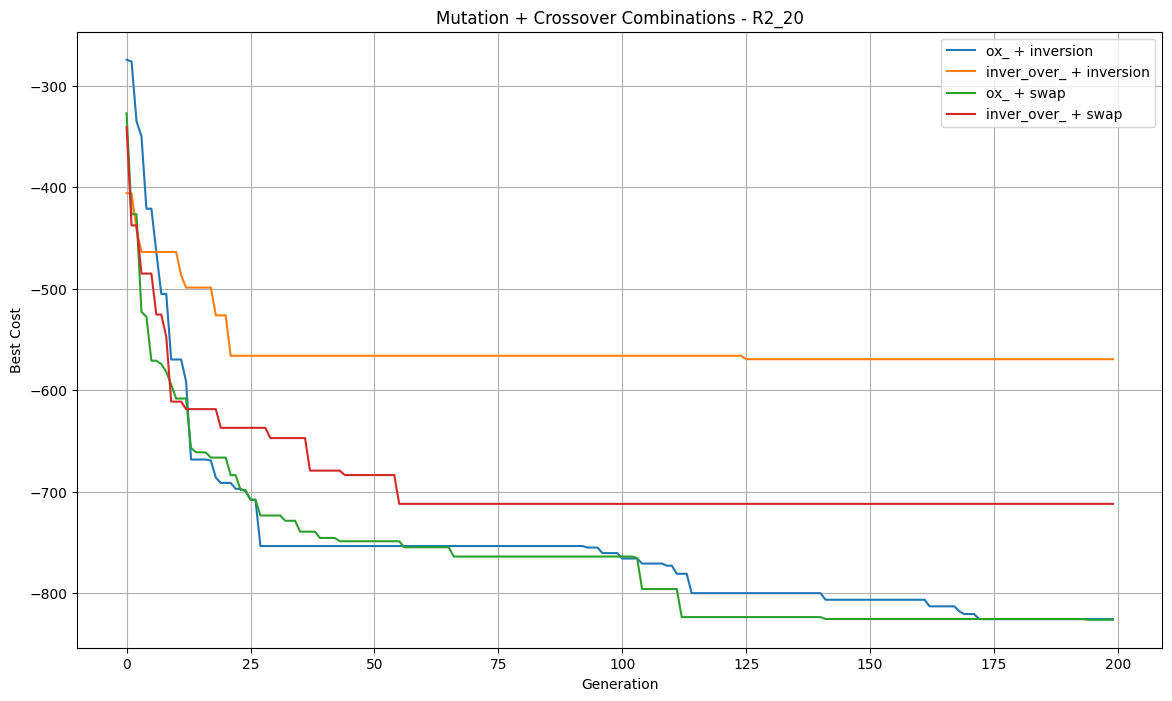

Best overall strategy: ox_ + swap
Best overall cost: -826.43
Best overall tour: [11  0  5 10 14 12  9 15 17 13  7 18  3 19  2  6 16  8  4  1]
PROBLEM: R2_50
ox_ + inversion -> Cost: -2212.05
inver_over_ + inversion -> Cost: -1483.94
ox_ + swap -> Cost: -2160.73
inver_over_ + swap -> Cost: -1964.95


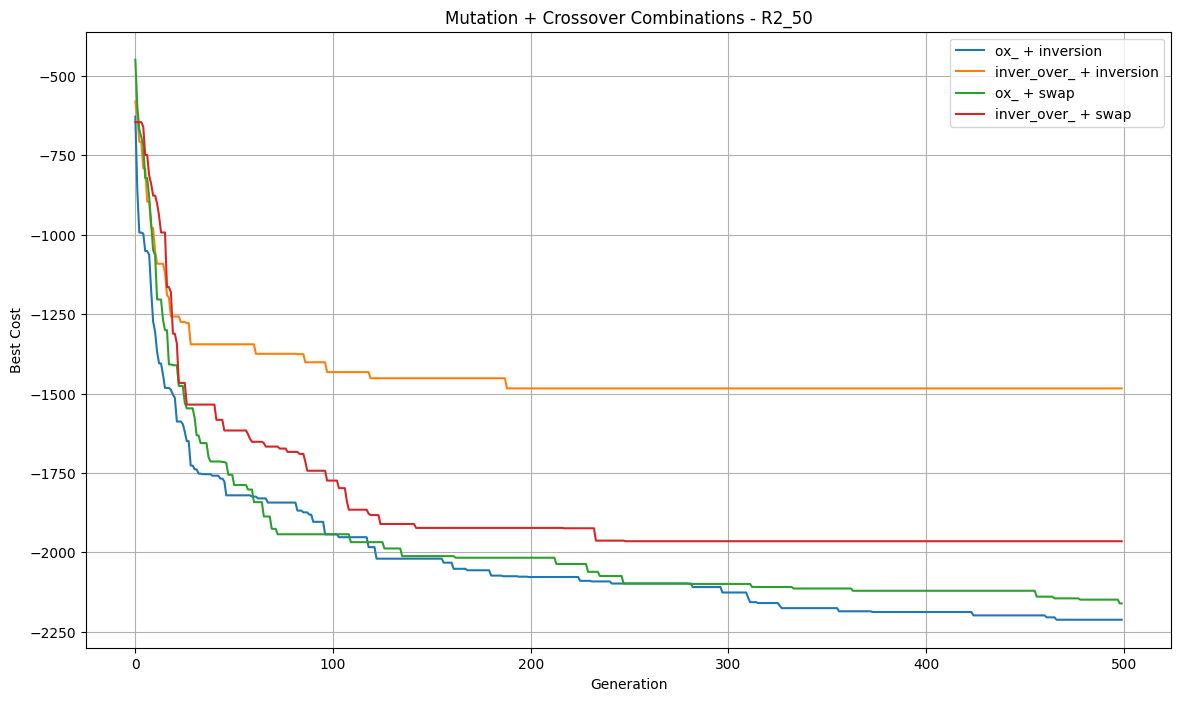

Best overall strategy: ox_ + inversion
Best overall cost: -2212.05
Best overall tour: [21 29  9 15 26 24  2 35 10 17 27 12 40  1  0 22 18 19 20  5 41 23  4 16
  6 39 36 49 30  3 42 43 46 25 13 28 38  7 11 32 47 48 34 31 14 37 45 44
  8 33]
PROBLEM: R2_100
ox_ + inversion -> Cost: -4419.41
inver_over_ + inversion -> Cost: -2727.79
ox_ + swap -> Cost: -4401.84
inver_over_ + swap -> Cost: -4066.06


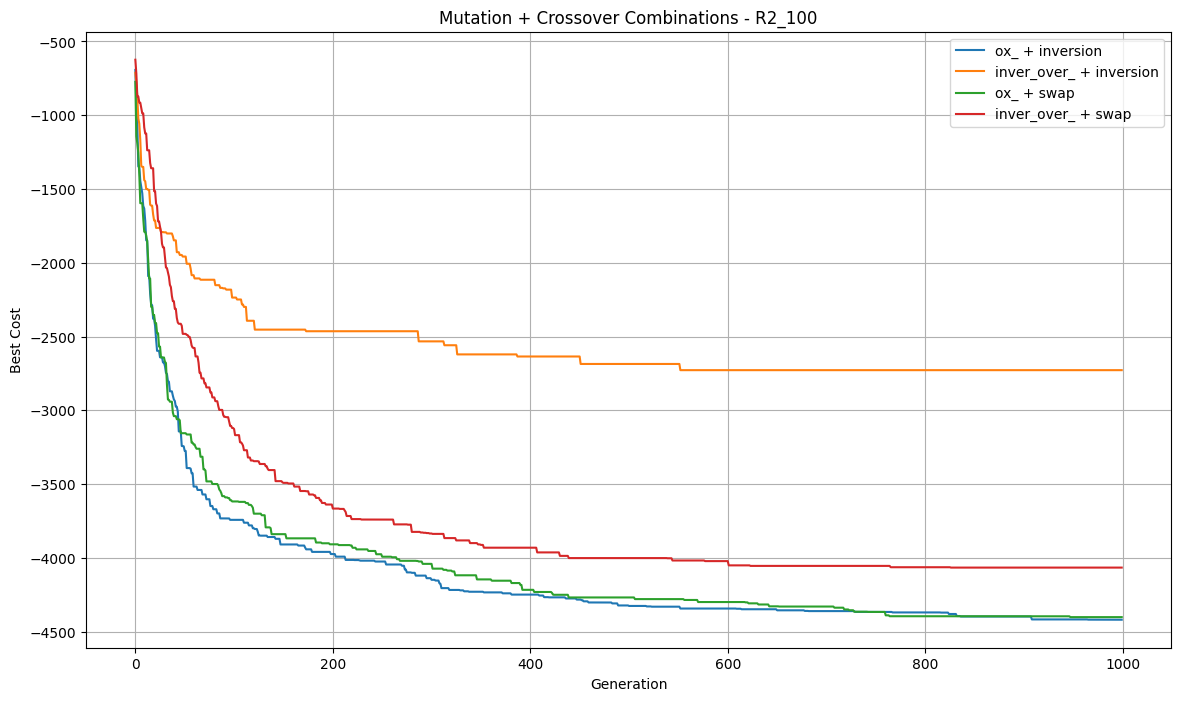

Best overall strategy: ox_ + inversion
Best overall cost: -4419.41
Best overall tour: [78 48 35 43 65 80 52 49 99 11 23  5 73 47 77 19 67 72 98 16 15 75 71 79
 97 44 90 28  9 41 63 56 14 89 29 87 58 92  1  0 74 20 33 70 91  7  6 45
 68 93 88 50 53 17 66  2 76 31 51 12 62 81 27 32 25 42 84 60  8 85 39 64
 40 57 61 82 18 22 86 55  3 13 37  4 34 94 38 30 36 26 24 96 21 83 59 95
 10 69 46 54]
PROBLEM: R2_200
ox_ + inversion -> Cost: -8978.42
inver_over_ + inversion -> Cost: -5265.75
ox_ + swap -> Cost: -8988.72
inver_over_ + swap -> Cost: -8255.70


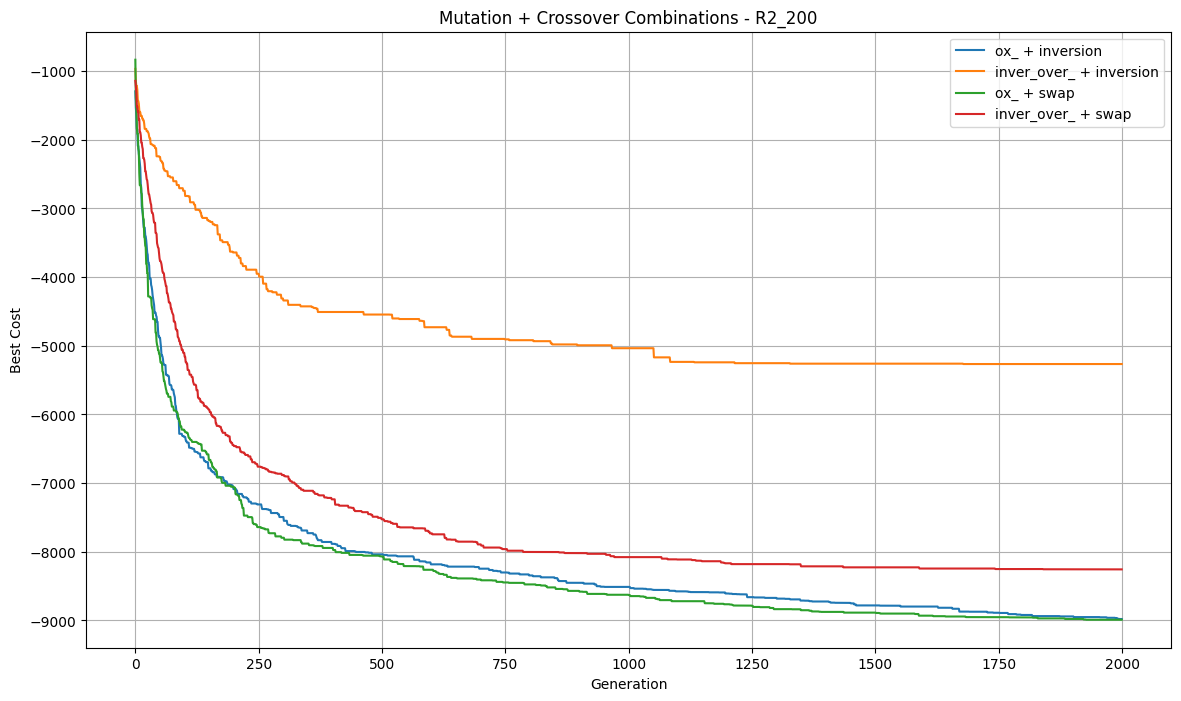

Best overall strategy: ox_ + swap
Best overall cost: -8988.72
Best overall tour: [ 97  56 166 189 178 190 130  70  18 118  47 153  64 145  25 127 107 159
 154  59 136 144 119   4 128  55  13 134 103 105  15  52 100  22  39 163
 184  91 198 114 161  77  80 150  81  92  76  51  99  41 102 135   9 131
  85  96   3  79 157 141 196 179  66  84 126  78 162 147   0 149  53 124
  62  30 152  67 112  34 172   1 173  44  26  16  27 123  12 169 156 115
 138 104 176  65  17 160  37  60   6 109 151  50   7 197  23  83 186 155
  42   2  19  31  45 158  46 174  94  43 110 182 164 165  68  14 148 111
  38 195  48   8 117  74 187  63 170  89  98  36 193 116 142 139 122 181
   5 177 132 113 194  40  69  11 137 168  20  35  88 188  29 146 143  24
  49 185  95 108  75 120 129 106 140 183  72  58 192 191 171 125 175  32
  21 180  87  71  28  93  57 167  54  61  86 133 121  10  73  82 199 101
  33  90]
PROBLEM: R2_500
ox_ + inversion -> Cost: -22614.17
inver_over_ + inversion -> Cost: -12202.29
ox_ + swap -

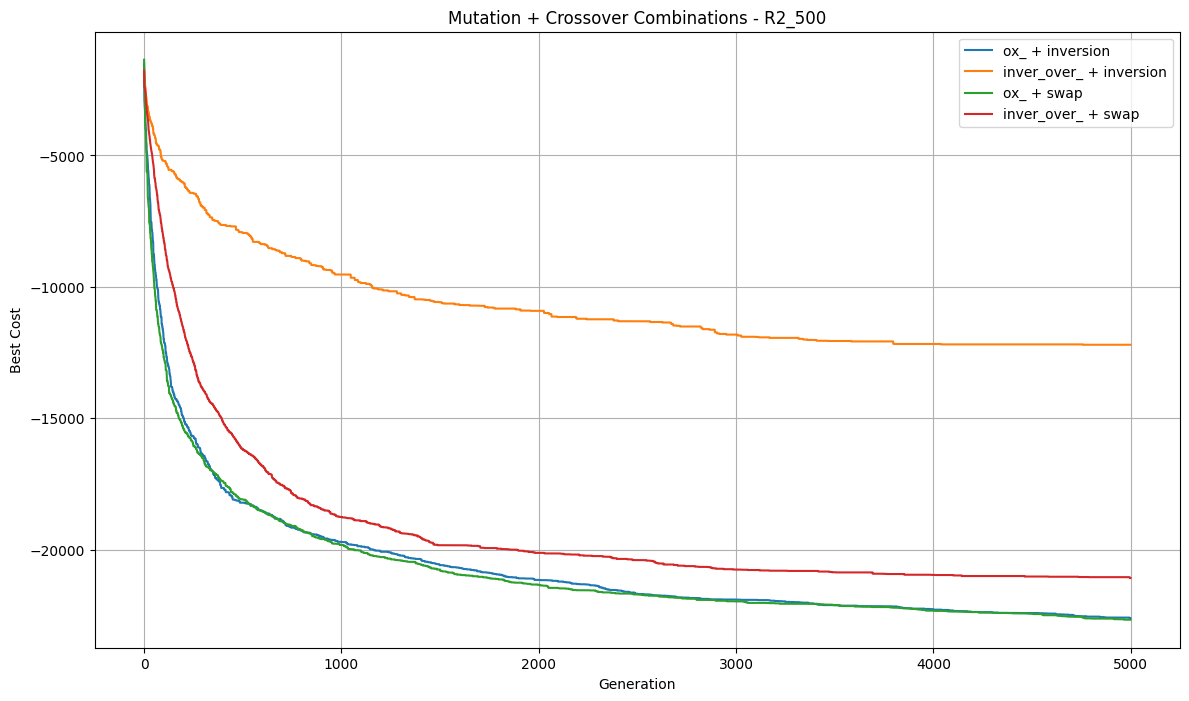

Best overall strategy: ox_ + swap
Best overall cost: -22665.34
Best overall tour: [ 86 274 471 209  65 276 481 407  72 383 359 352 444  26 147  30 417 153
 312 344 336 499 480 355 216 165  93  14 252 486  16  47 335 221 493 208
 104 255 456 326  19 377 265 340 224 205 412 374 368 286  52 127  36 148
 297 162 305 248 246  51 124 299 404 484  21 423 285 192 339 474 430 132
  71 371  41 143 271 186 303 345 408  89 325 464 485 231 428 398  24 365
 402 108 202 349 413 320 356 146 239 476 460 242 114 212 111  63 473 328
 249 272 240 421 358  82  75 229  28 295 331 238 362 176 260 483 213  10
  18  94 135 306 187 478 479 110 361  55 173  67   1 415  34 387 425 318
 254 490 170  39 117 151  76 182 220 446 237 122 197 314 400  25 269  60
  37 393 416 296 123 447 199 228 445 379 375 366 195 477  88 382  44 455
  38 487  91  70 451  66 294 472 134  53 419 458  31 261 163 467 392 434
 360 139 266 364 491 128 223 316 409 338 258  46 288  22 347 141 232   4
  27 292   0 149 244 298  29 171 177 380  

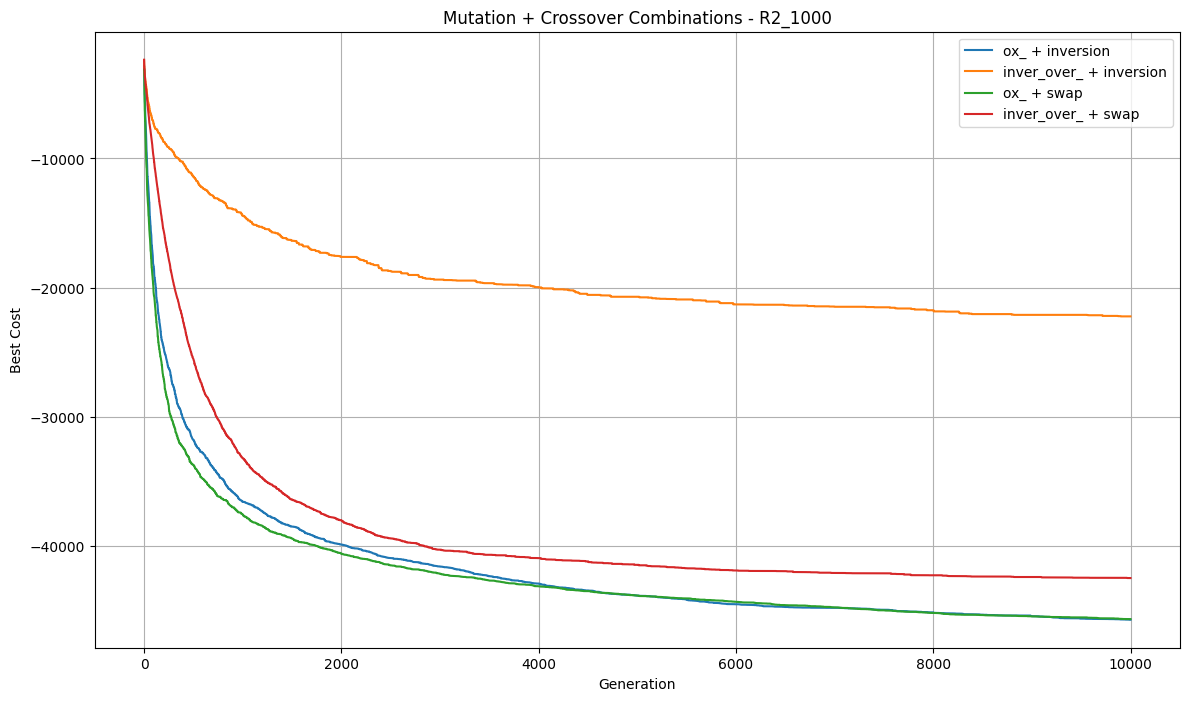

Best overall strategy: ox_ + inversion
Best overall cost: -45691.84
Best overall tour: [993 561 902 954 618 681 925 403 571 696 485 439 717 649 778 980 620 135
  84 763  47 277 354 429 123 217 896 491 352 944 179  99 834 142 625 755
 118 845 612 443 238 279 702 339 378 976  89 670 819 841 432 651 208  93
  69  18  32 272  77 391  91 425 570 492 861 298  75 669 127 215 789 892
 219 469 856  67 938 838 290 747 168 111 284 187 855 120 131 631 663 719
 263 687 529 519 323 700  14 977 495 163 591 481 908 324 308 117 683 467
 950 325 898 657 246 192 289 197 912 259  43 744 155 739 270  23 385 903
  44 199  36 457  54 140 273 983 343 517 451 134 542 727 407 342 808 430
  61 113 728 615 544   6  81 129 813 962 862 741 149 554 646 991  65 499
 216  25  66 496 376 974 567 866 594 146 910 656 629 666 711 765 997 764
 423 891 475 335 710 985   1 682  41 640 383 400 164 706 231 982 302 672
 748 389 252 340 362 387 501 953  80  59 249 572 303 108 487 674 587 204
 520 125 360 660 842 857 247 648 817 

(array([993, 561, 902, 954, 618, 681, 925, 403, 571, 696, 485, 439, 717,
        649, 778, 980, 620, 135,  84, 763,  47, 277, 354, 429, 123, 217,
        896, 491, 352, 944, 179,  99, 834, 142, 625, 755, 118, 845, 612,
        443, 238, 279, 702, 339, 378, 976,  89, 670, 819, 841, 432, 651,
        208,  93,  69,  18,  32, 272,  77, 391,  91, 425, 570, 492, 861,
        298,  75, 669, 127, 215, 789, 892, 219, 469, 856,  67, 938, 838,
        290, 747, 168, 111, 284, 187, 855, 120, 131, 631, 663, 719, 263,
        687, 529, 519, 323, 700,  14, 977, 495, 163, 591, 481, 908, 324,
        308, 117, 683, 467, 950, 325, 898, 657, 246, 192, 289, 197, 912,
        259,  43, 744, 155, 739, 270,  23, 385, 903,  44, 199,  36, 457,
         54, 140, 273, 983, 343, 517, 451, 134, 542, 727, 407, 342, 808,
        430,  61, 113, 728, 615, 544,   6,  81, 129, 813, 962, 862, 741,
        149, 554, 646, 991,  65, 499, 216,  25,  66, 496, 376, 974, 567,
        866, 594, 146, 910, 656, 629, 666, 711, 765

In [288]:
# R2_10 problem
test_problem('lab2/problem_r2_10.npy', "R2_10", population_size=50, generations=100)

# R2_20 problem
test_problem('lab2/problem_r2_20.npy', "R2_20", population_size=60, generations=200)

# R2_50 problem
test_problem('lab2/problem_r2_50.npy', "R2_50", population_size=80, generations=500)

# R2_100 problem
test_problem('lab2/problem_r2_100.npy', "R2_100", population_size=100, generations=1000)

# R2_200 problem
test_problem('lab2/problem_r2_200.npy', "R2_200", population_size=120, generations=2000)

# R2_500 problem
test_problem('lab2/problem_r2_500.npy', "R2_500", population_size=150, generations=5000)

# R2_1000 problem
test_problem('lab2/problem_r2_1000.npy', "R2_1000", population_size=200, generations=10000)